# Regression Metrics and Visualization Techniques Notebook

**Notebook Contents Structure**

1. Introduction and Dataset Preparation (Dataset: California Housing (real-world housing price data), Data exploration and preprocessin, Train-test split with proper sampling)
2. Regression Metrics Implementation(Error-based metrics (MSE, RMSE, MAE), Percentage-based metrics (MAPE, SMAPE), Robust metrics (Huber Loss, MSLE),Goodness-of-fit metrics (R², Adjusted R²),Scale-independent metrics (Explained Variance))
3. Visualization Techniques
- **Error Distribution Analysis**(Residual plots and patterns,QQ plots for normality assessment,Error histograms by feature ranges)
- **Model Performance Visualization**(Actual vs. predicted plots,Residual distribution analysis,Feature-specific error analysis)
- **Training Dynamics**(Learning curves analysis,Overfitting/underfitting detection,Validation curves for hyperparameters)
4. Model Optimization and Insights(Error analysis by data segments,Feature importance visualization,Threshold-based error analysis,Business impact assessment)

In [1]:
# Libraries & dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Metrics imports
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                           r2_score, explained_variance_score,
                           mean_squared_log_error, median_absolute_error,
                           max_error)

# Model imports
from sklearn.model_selection import (train_test_split, cross_val_score,
                                   learning_curve, validation_curve,
                                   GridSearchCV, KFold)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

# Stats imports
from scipy import stats
import scipy.optimize as opt
from statsmodels.graphics.gofplots import qqplot

In [2]:
# Custom plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Custom functions for additional metrics not in sklearn
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE, handling zeros in y_true"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Remove zeros to avoid division by zero
    mask = y_true != 0
    y_true, y_pred = y_true[mask], y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """Calculate SMAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def huber_loss(y_true, y_pred, delta=1.0):
    """Calculate Huber Loss"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    errors = y_true - y_pred
    abs_errors = np.abs(errors)
    quadratic = np.minimum(abs_errors, delta)
    linear = abs_errors - quadratic
    return np.mean(0.5 * quadratic ** 2 + delta * linear)

def adjusted_r2_score(y_true, y_pred, n_features):
    """Calculate Adjusted R²"""
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

## Data Loading and Exploration

In [3]:
# California Housing Dataset
from sklearn.datasets import fetch_california_housing

# Load the data
housing = fetch_california_housing()
X, y = housing.data, housing.target

# Create a DataFrame
data = pd.DataFrame(X, columns=housing.feature_names)
data['price'] = y

In [4]:
# Summary statistics
print("\nSummary Statistics:")
display(data.describe())

# Visualize distributions
plt.figure(figsize=(15, 10))


Summary Statistics:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 0, 'Price ($100,000s)')

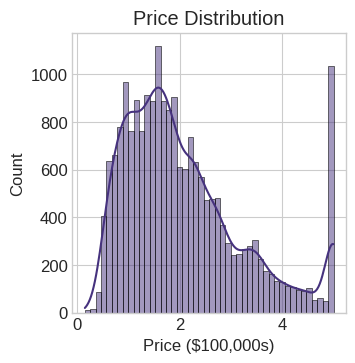

In [5]:
# Price distribution
plt.subplot(2, 3, 1)
sns.histplot(data['price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price ($100,000s)')

Text(0, 0.5, 'Price ($100,000s)')

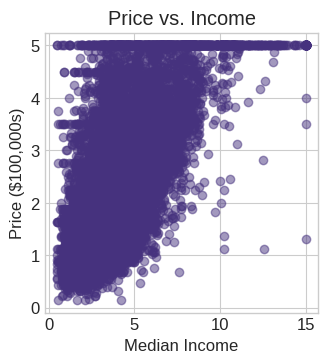

In [6]:
# Price vs Income scatter
plt.subplot(2, 3, 2)
plt.scatter(data['MedInc'], data['price'], alpha=0.5)
plt.title('Price vs. Income')
plt.xlabel('Median Income')
plt.ylabel('Price ($100,000s)')

Text(0, 0.5, 'Price ($100,000s)')

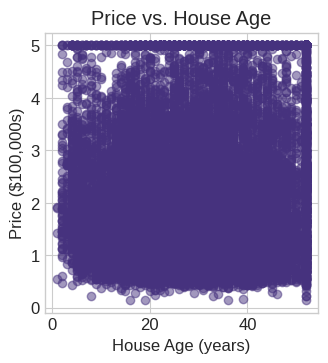

In [7]:
# Price vs HouseAge scatter
plt.subplot(2, 3, 3)
plt.scatter(data['HouseAge'], data['price'], alpha=0.5)
plt.title('Price vs. House Age')
plt.xlabel('House Age (years)')
plt.ylabel('Price ($100,000s)')

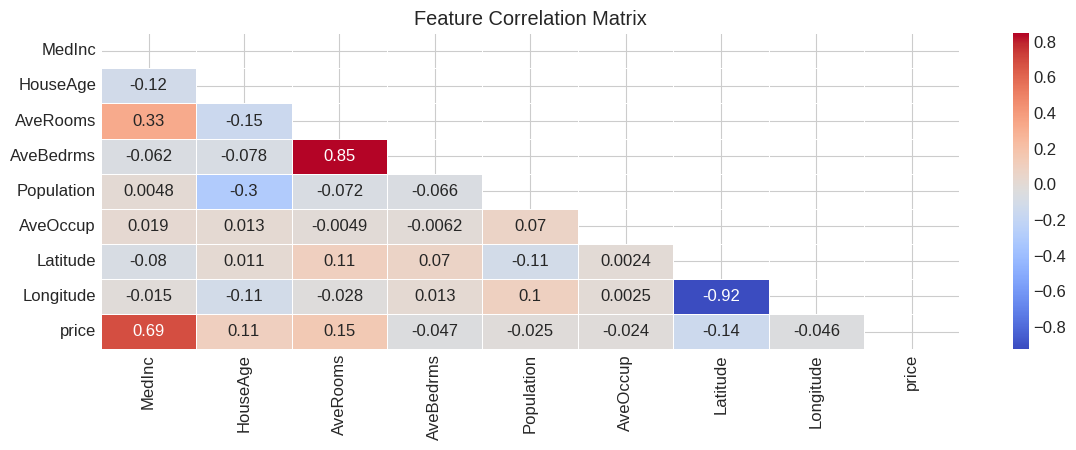

In [8]:
# Correlation heatmap
plt.subplot(2, 1, 2)
correlation = data.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

### Data Preprocessing

In [9]:
# Split features and target
X = data.drop('price', axis=1)
y = data['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Feature names for later reference
feature_names = X.columns

# Initialize cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Create processing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

## Model Training and Basic Evaluation

In [10]:
# Define the models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.01, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [11]:
# Basic metrics to evaluate
def evaluate_model(y_true, y_pred, n_features):
    """Calculate and return all regression metrics"""
    metrics = {}

    # Error-based metrics
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)

    # Percentage-based metrics
    metrics['MAPE'] = mean_absolute_percentage_error(y_true, y_pred)
    metrics['SMAPE'] = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    # Robust metrics
    try:
        metrics['MSLE'] = mean_squared_log_error(y_true, y_pred)
    except:
        # If there are negative predictions
        metrics['MSLE'] = np.nan

    metrics['Huber'] = huber_loss(y_true, y_pred)
    metrics['Median AE'] = median_absolute_error(y_true, y_pred)
    metrics['Max Error'] = max_error(y_true, y_pred)

    # Goodness-of-fit metrics
    metrics['R²'] = r2_score(y_true, y_pred)
    metrics['Adjusted R²'] = adjusted_r2_score(y_true, y_pred, n_features)
    metrics['Explained Variance'] = explained_variance_score(y_true, y_pred)

    return metrics

In [12]:
# Training and evaluation results
results = {}
y_pred_dict = {}
all_metrics = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Create pipeline with current model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Store predictions
    y_pred_dict[name] = y_pred

    # Calculate metrics
    all_metrics[name] = evaluate_model(y_test, y_pred, X.shape[1])

# Convert metrics to DataFrame for easier comparison
metrics_df = pd.DataFrame(all_metrics).T

# Round for better display
metrics_df = metrics_df.round(4)

# Display all metrics sorted by R²
display(metrics_df.sort_values('R²', ascending=False))

Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...


,MSE,RMSE,MAE,MAPE,SMAPE,MSLE,Huber,Median AE,Max Error,R²,Adjusted R²,Explained Variance
Random Forest,0.2542,0.5042,0.3291,19.1095,16.6398,0.0227,0.1136,0.2049,3.6355,0.8079,0.8076,0.8080
Gradient Boosting,0.2895,0.5381,0.3712,21.6804,19.2514,0.0268,0.1297,0.2549,4.0036,0.7812,0.7809,0.7812
Decision Tree,0.4177,0.6463,0.4320,25.4978,21.9451,0.0388,0.1753,0.2792,4.6000,0.6843,0.6839,0.6845
Lasso Regression,0.5357,0.7319,0.5322,32.0638,28.1683,0.0512,0.2251,0.4167,7.0103,0.5951,0.5945,0.5951
Ridge Regression,0.5411,0.7356,0.5297,31.9776,28.5219,NaN,0.2241,0.4098,10.0601,0.5911,0.5904,0.5911
Linear Regression,0.5411,0.7356,0.5297,31.9784,28.5255,NaN,0.2241,0.4099,10.0683,0.5911,0.5904,0.5911


## Error Distribution Analysis

In [13]:
def plot_residuals(y_true, y_pred, title='Residual Plot'):
    """Create a comprehensive residual plot with annotations"""
    # Calculate residuals
    residuals = y_true - y_pred

    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Scatter plot of predicted vs residuals
    scatter = ax.scatter(y_pred, residuals, alpha=0.6, c=residuals, cmap='coolwarm')

    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Add a trend line to highlight patterns
    z = np.polyfit(y_pred, residuals, 1)
    p = np.poly1d(z)
    ax.plot(np.sort(y_pred), p(np.sort(y_pred)), "r--", lw=2,
           label=f"Trend: y={z[0]:.4f}x + {z[1]:.4f}")

    # Calculate stats about residuals
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # Add reference lines for mean and +/- 2 std dev
    ax.axhline(y=mean_residual, color='green', linestyle='--', alpha=0.8,
              label=f'Mean = {mean_residual:.4f}')
    ax.axhline(y=mean_residual + 2*std_residual, color='red', linestyle='--', alpha=0.5,
              label=f'+2σ = {mean_residual + 2*std_residual:.4f}')
    ax.axhline(y=mean_residual - 2*std_residual, color='red', linestyle='--', alpha=0.5,
              label=f'-2σ = {mean_residual - 2*std_residual:.4f}')

    # Identify potential outliers
    outliers = np.abs(residuals) > 2*std_residual
    if np.sum(outliers) > 0:
        ax.scatter(y_pred[outliers], residuals[outliers], s=50, facecolors='none',
                  edgecolors='red', label=f'Outliers: {np.sum(outliers)}')

    # Add a colorbar to show the residual magnitude
    cbar = plt.colorbar(scatter)
    cbar.set_label('Residual Value')

    # Annotations for patterns
    slope = z[0]
    if abs(slope) > 0.05:
        pattern_text = "Non-random pattern detected: Possible non-linearity"
        color = "red"
    else:
        pattern_text = "Residuals appear randomly distributed"
        color = "green"

    ax.text(0.05, 0.05, pattern_text, transform=ax.transAxes,
           bbox=dict(facecolor=color, alpha=0.2))

    # Styling
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, residuals

def plot_qq(residuals, title='Normal Q-Q Plot'):
    """Create a quantile-quantile plot for residuals"""
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create Q-Q plot
    pp_x = sm.ProbPlot(residuals, fit=True)
    qq_plot = pp_x.qqplot(line='45', ax=ax, markersize=5, alpha=0.6, color='blue')

    # Add a title and labels
    ax.set_title(title)
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')

    # Perform Shapiro-Wilk test for normality
    stat, p = stats.shapiro(residuals)

    # Annotation with test results
    if p > 0.05:
        normality_text = f"Residuals are normally distributed (p={p:.4f})"
        color = "green"
    else:
        normality_text = f"Residuals are NOT normally distributed (p={p:.4f})"
        color = "red"

    ax.text(0.05, 0.95, normality_text, transform=ax.transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))

    # Highlight deviations
    # Calculate the theoretical quantiles
    x_theoretical = stats.norm.ppf(np.linspace(0.01, 0.99, len(residuals)))
    x_theoretical.sort()  # Sort theoretical quantiles
    y_sorted = np.sort(residuals)

    # Find points deviating significantly from the line
    theoretical_y = np.mean(residuals) + np.std(residuals) * x_theoretical
    deviation = np.abs(y_sorted - theoretical_y)
    significant_deviation = deviation > np.std(deviation) * 2

    if np.sum(significant_deviation) > 0:
        # Mark points with significant deviation
        ax.scatter(x_theoretical[significant_deviation],
                  y_sorted[significant_deviation],
                  color='red', s=50, facecolors='none',
                  label=f'Significant deviations: {np.sum(significant_deviation)}')

    # Add a legend if there are significant deviations
    if np.sum(significant_deviation) > 0:
        ax.legend()

    plt.tight_layout()
    return fig

def plot_error_histogram(residuals, title='Residual Distribution'):
    """Create a histogram of residuals with distribution fit"""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a histogram of residuals
    n, bins, patches = ax.hist(residuals, bins=30, alpha=0.7, color='blue', density=True)

    # Fit a normal distribution
    mu, sigma = stats.norm.fit(residuals)

    # Create a normal distribution line
    x = np.linspace(min(residuals), max(residuals), 100)
    y = stats.norm.pdf(x, mu, sigma)
    ax.plot(x, y, 'r-', lw=2, label=f'Normal Fit: μ={mu:.4f}, σ={sigma:.4f}')

    # Mark mean, median, and mode
    ax.axvline(mu, color='red', linestyle='--', alpha=0.8, label=f'Mean={mu:.4f}')
    median = np.median(residuals)
    ax.axvline(median, color='green', linestyle='--', alpha=0.8, label=f'Median={median:.4f}')

    # Calculate skewness and kurtosis
    skewness = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals)

    # Annotation for distribution shape
    shape_text = []
    if abs(skewness) < 0.5:
        shape_text.append("Symmetric")
    elif skewness > 0:
        shape_text.append("Right-skewed")
    else:
        shape_text.append("Left-skewed")

    if abs(kurtosis) < 0.5:
        shape_text.append("Mesokurtic (normal)")
    elif kurtosis > 0:
        shape_text.append("Leptokurtic (heavy tails)")
    else:
        shape_text.append("Platykurtic (light tails)")

    ax.text(0.05, 0.95, f"Distribution: {', '.join(shape_text)}\nSkewness: {skewness:.4f}\nKurtosis: {kurtosis:.4f}",
           transform=ax.transAxes, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))

    # Styling
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_error_by_feature(X, residuals, feature_name, n_bins=10, title=None):
    """Show how errors vary across different ranges of a feature"""
    # Get the feature values
    feature_values = X[feature_name].values

    # Create bins
    bins = pd.cut(feature_values, n_bins)

    # Group residuals by bin
    grouped_residuals = pd.DataFrame({
        'feature': feature_values,
        'residual': residuals,
        'bin': bins
    }).groupby('bin')

    # Calculate statistics for each bin
    stats = grouped_residuals.agg({
        'residual': ['mean', 'median', 'std', 'count'],
        'feature': ['mean']
    }).reset_index()

    # Flatten column names
    stats.columns = ['bin', 'residual_mean', 'residual_median',
                   'residual_std', 'count', 'feature_mean']

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 12))

    # Box plot of residuals by bin
    sns.boxplot(x='bin', y='residual', data=pd.DataFrame({
        'bin': bins,
        'residual': residuals
    }), ax=ax)

    # Add mean markers
    ax.scatter(range(len(stats)), stats['residual_mean'], marker='o',
              color='red', s=50, label='Mean')

    # Connect means
    ax.plot(range(len(stats)), stats['residual_mean'], 'r--')

    # Add zero reference line
    ax.axhline(y=0, color='green', linestyle='-', alpha=0.3)

    # Add count annotations
    for i, (_, row) in enumerate(stats.iterrows()):
        ax.annotate(f"n={int(row['count'])}",
                   (i, ax.get_ylim()[0] * 0.9),
                   ha='center')

    # Check for patterns
    corr = np.corrcoef(stats['feature_mean'], stats['residual_mean'])[0, 1]

    if abs(corr) > 0.3:
        pattern_text = f"Pattern detected: Correlation = {corr:.4f}"
        color = "red"
        ax.text(0.05, 0.05, pattern_text, transform=ax.transAxes,
               bbox=dict(facecolor=color, alpha=0.2))

    # Styling
    if title is None:
        title = f'Residuals by {feature_name}'
    ax.set_title(title)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Residual')

    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    return fig

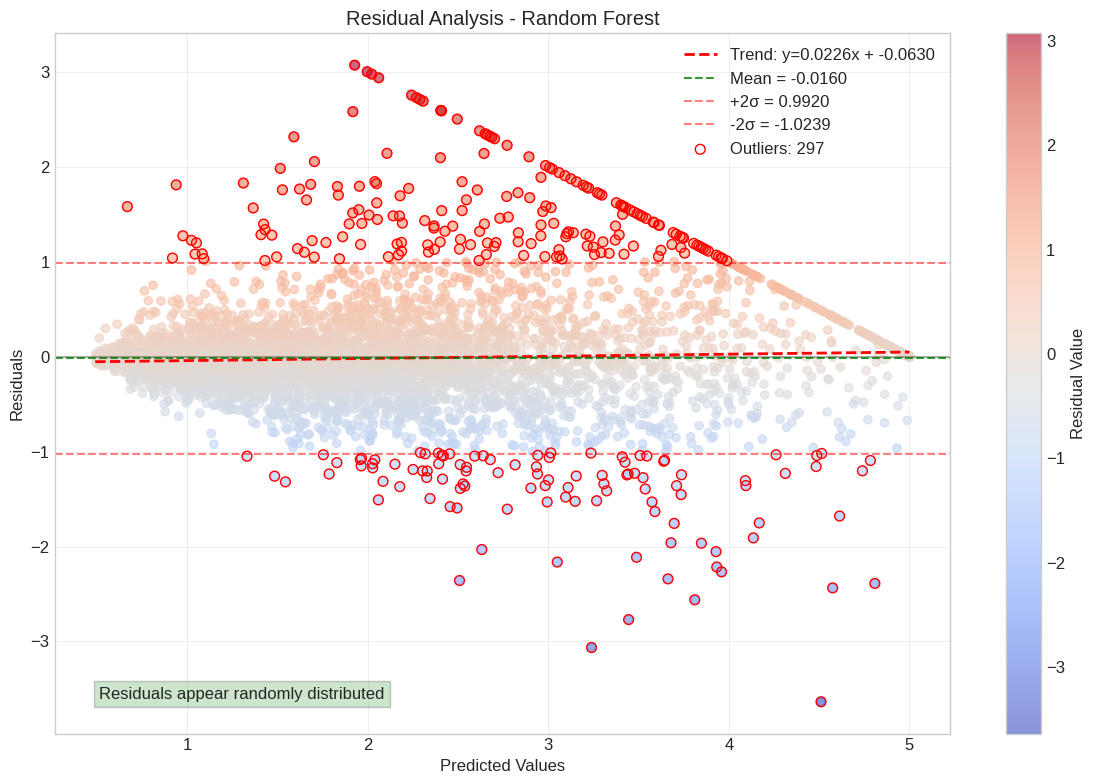

In [14]:
# For the best model, analyze error distribution
best_model = metrics_df['R²'].idxmax()
residuals_fig, residuals = plot_residuals(y_test, y_pred_dict[best_model],
                                         title=f'Residual Analysis - {best_model}')
plt.show()

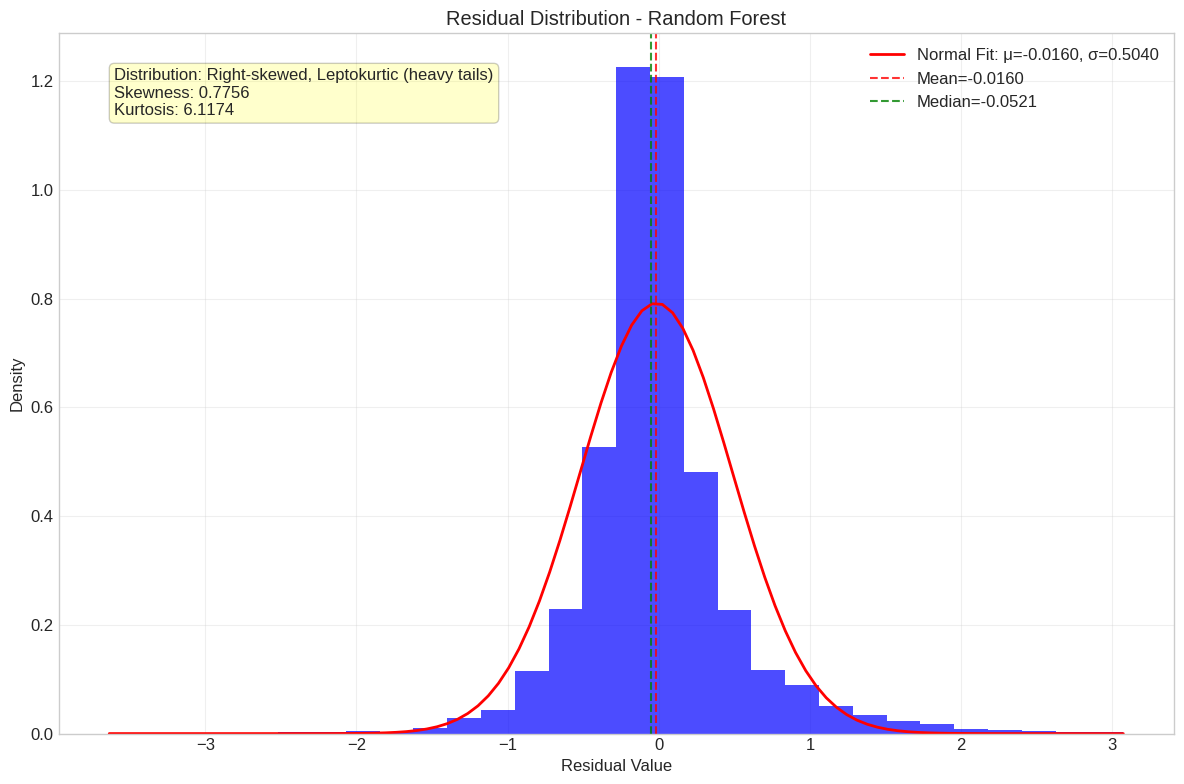

In [15]:
# Error Histogram
hist_fig = plot_error_histogram(residuals, title=f'Residual Distribution - {best_model}')
plt.show()

In [16]:
# Error by feature for top correlated features
correlation_with_price = abs(data.corr()['price']).sort_values(ascending=False)
top_features = correlation_with_price.index[1:4]  # Skip price itself

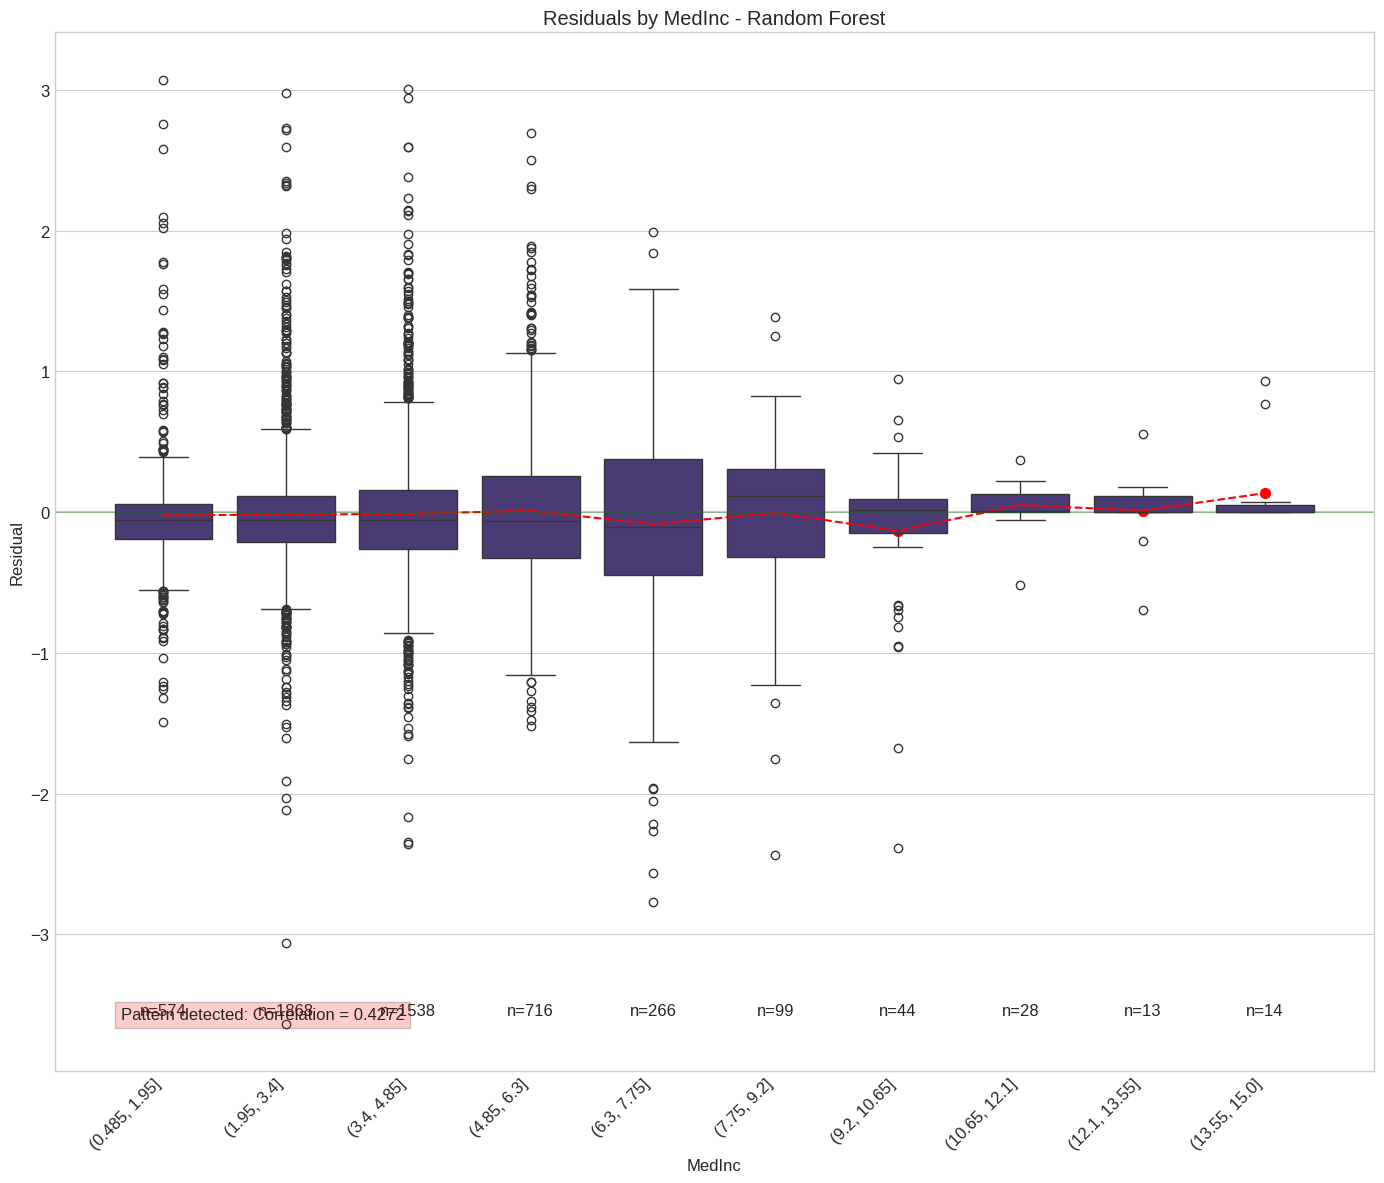

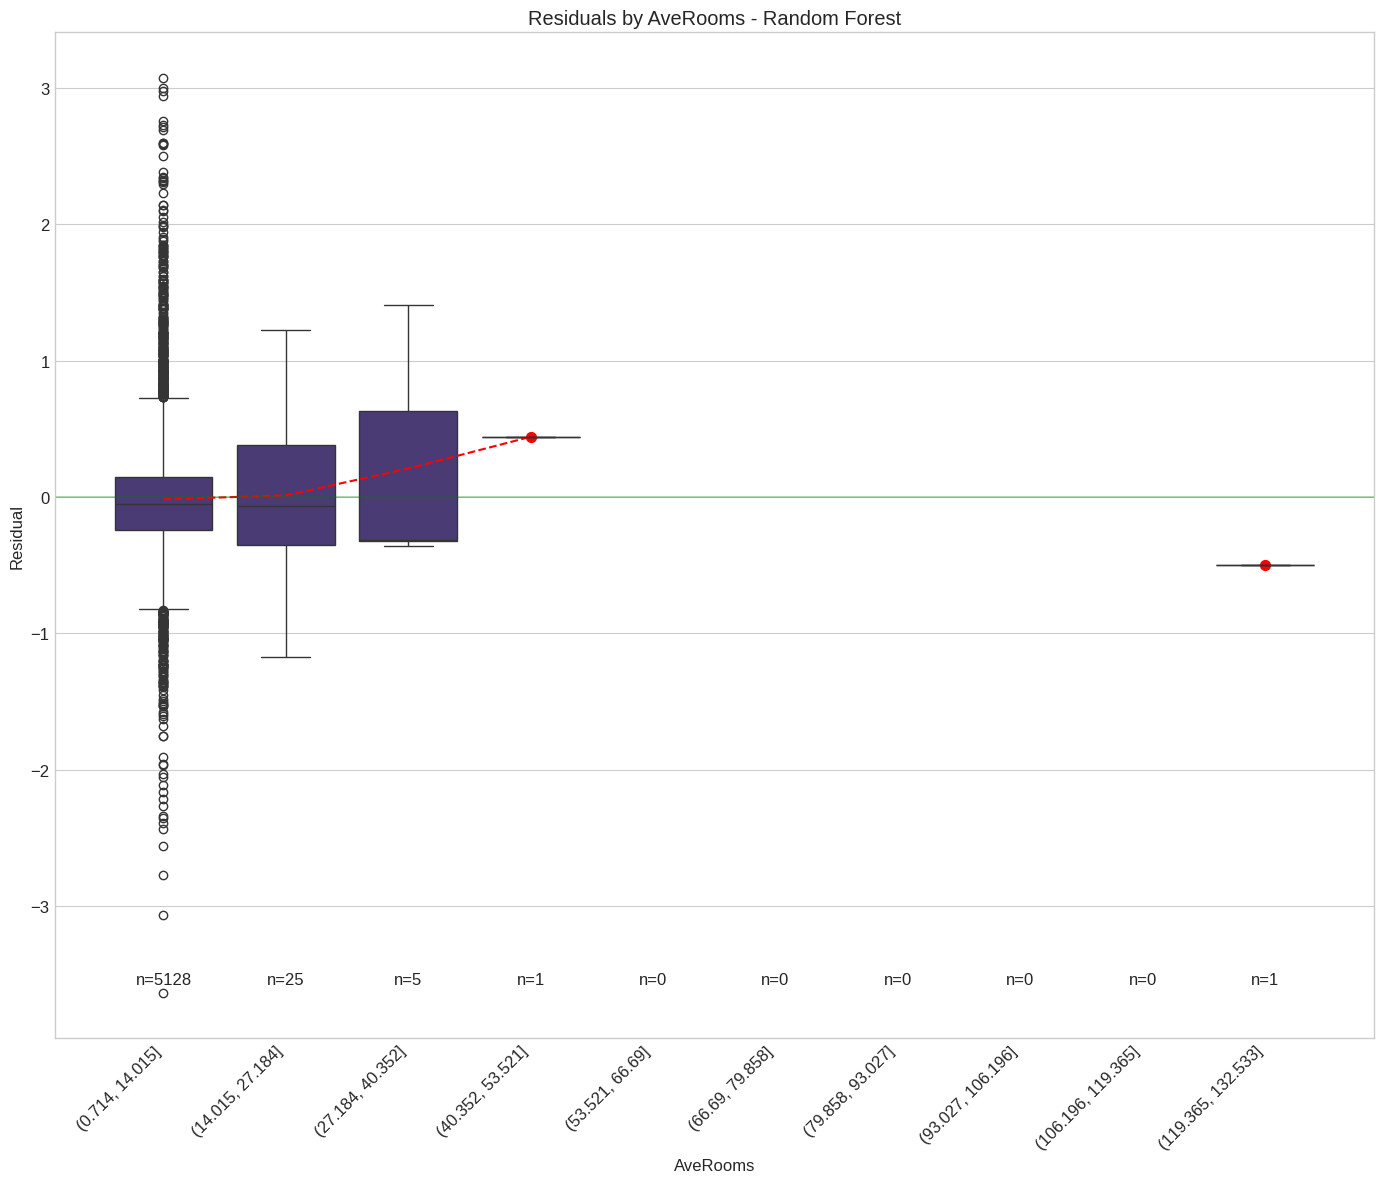

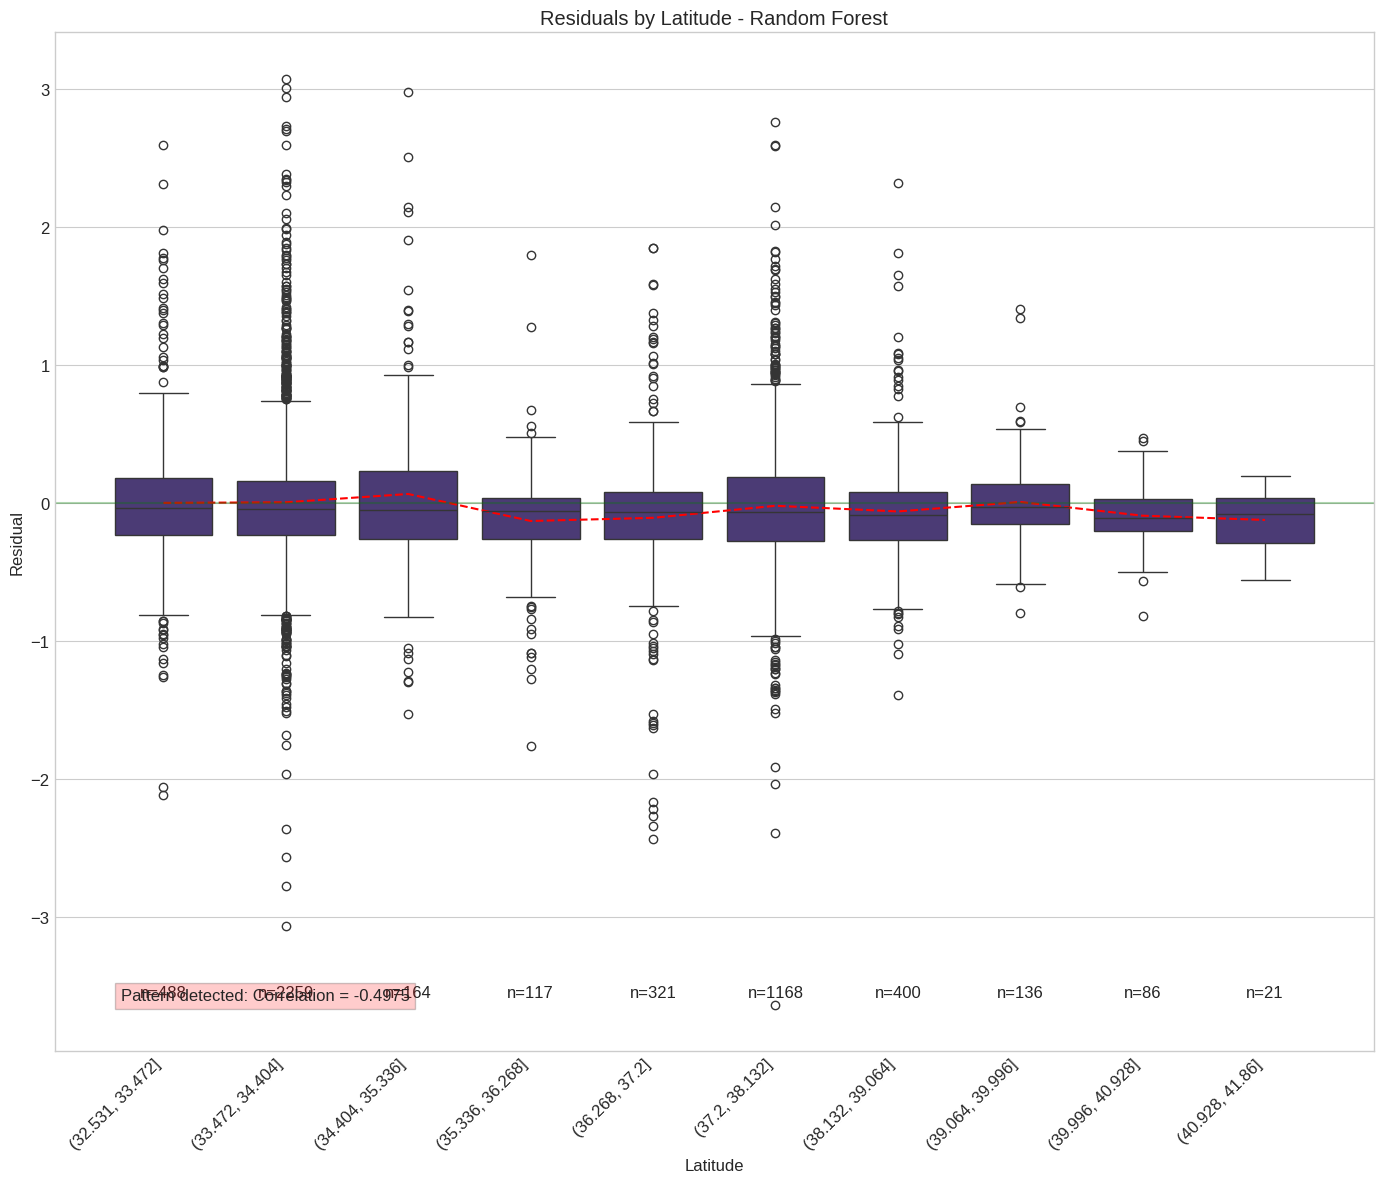

In [17]:
for feature in top_features:
    feature_fig = plot_error_by_feature(X_test, residuals, feature,
                                       title=f'Residuals by {feature} - {best_model}')
    plt.show()

## Actual vs. Predicted Visualization

In [18]:
def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs. Predicted'):
    """Create a scatter plot of actual vs. predicted values with analysis"""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Scatter plot
    scatter = ax.scatter(y_true, y_pred, alpha=0.6, c=abs(y_true - y_pred), cmap='viridis')

    # Add a reference line for perfect predictions
    max_val = max(np.max(y_true), np.max(y_pred))
    min_val = min(np.min(y_true), np.min(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')

    # Add trend line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    ax.plot(np.sort(y_true), p(np.sort(y_true)), "r-",
           label=f"Fitted Line: y={z[0]:.4f}x + {z[1]:.4f}")

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Add a region showing the RMSE band around perfect prediction
    x = np.linspace(min_val, max_val, 100)
    ax.fill_between(x, x - rmse, x + rmse, alpha=0.1, color='red',
                   label=f'RMSE Band: {rmse:.4f}')

    # Add annotations for key metrics
    ax.text(0.05, 0.95, f"R² = {r2:.4f}\nRMSE = {rmse:.4f}", transform=ax.transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Add pattern observations
    if z[0] > 1.05:
        ax.text(0.05, 0.05, "Model tends to overestimate high values", transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
    elif z[0] < 0.95:
        ax.text(0.05, 0.05, "Model tends to underestimate high values", transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))

    # Add a colorbar to show the error magnitude
    cbar = plt.colorbar(scatter)
    cbar.set_label('Absolute Error')

    # Styling
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(title)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_residuals_3d(X, y_true, y_pred, feature1, feature2, title=None):
    """Create a 3D visualization of residuals by two features"""
    # Calculate residuals
    residuals = y_true - y_pred
    abs_residuals = np.abs(residuals)

    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot
    scatter = ax.scatter(X[feature1], X[feature2], residuals, c=abs_residuals,
                        cmap='viridis', s=50, alpha=0.6)

    # Add a reference plane at residual=0
    x_range = np.linspace(min(X[feature1]), max(X[feature1]), 10)
    y_range = np.linspace(min(X[feature2]), max(X[feature2]), 10)
    X_grid, Y_grid = np.meshgrid(x_range, y_range)
    Z_grid = np.zeros_like(X_grid)
    ax.plot_surface(X_grid, Y_grid, Z_grid, alpha=0.1, color='gray')

    # Add a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Absolute Residual')

    # Styling
    if title is None:
        title = f'Residuals by {feature1} and {feature2}'
    ax.set_title(title)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel('Residual')

    plt.tight_layout()
    return fig

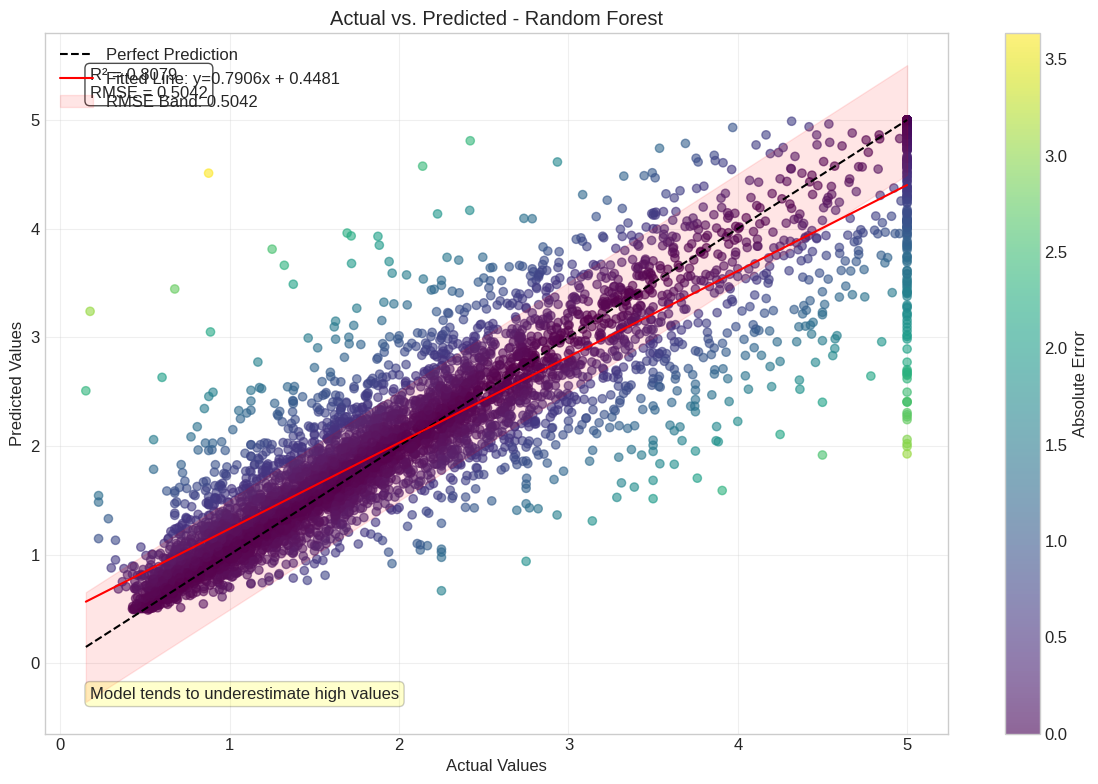

In [19]:
# Plot actual vs. predicted for best model
avp_fig = plot_actual_vs_predicted(y_test, y_pred_dict[best_model],
                                 title=f'Actual vs. Predicted - {best_model}')
plt.show()

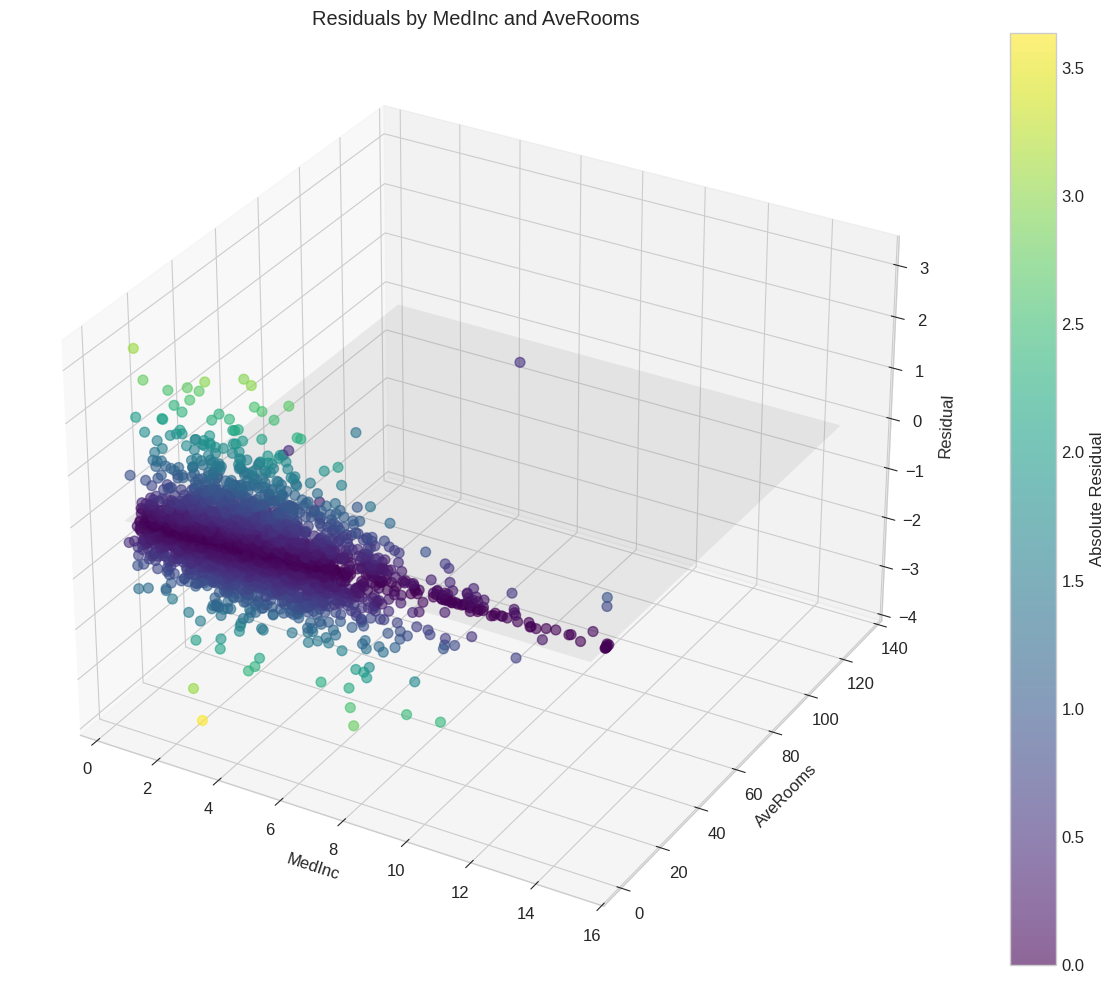

In [20]:
# 3D residual plot for two important features
if len(top_features) >= 2:
    residuals_3d_fig = plot_residuals_3d(X_test, y_test, y_pred_dict[best_model],
                                       top_features[0], top_features[1])
    plt.show()

## Learning Curves and Training Dynamics

In [21]:
def plot_learning_curves(estimator, X, y, title=None):
    """
    Plot learning curves showing training and validation scores
    with annotations for overfitting/underfitting
    """
    # Setup cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create pipeline with preprocessing
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', estimator)
    ])

    # Calculate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2', random_state=42
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Create the plot
    plt.figure(figsize=(14, 8))
    plt.grid()

    # Plot the learning curves with error bands
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std,
                     val_mean + val_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation score')

    # Diagnose overfitting/underfitting
    gap = train_mean[-1] - val_mean[-1]
    train_max = train_mean[-1]
    val_max = val_mean[-1]

    # Add diagnosis text
    if gap > 0.1 and train_max > 0.8:
        plt.text(train_sizes[-1]*0.7, 0.3, "Overfitting",
                fontsize=16, bbox=dict(facecolor='red', alpha=0.2))
        diagnosis = "Overfitting"
    elif train_max < 0.7 and val_max < 0.7:
        plt.text(train_sizes[-1]*0.7, 0.3, "Underfitting",
                fontsize=16, bbox=dict(facecolor='blue', alpha=0.2))
        diagnosis = "Underfitting"
    else:
        plt.text(train_sizes[-1]*0.7, 0.3, "Good Fit",
                fontsize=16, bbox=dict(facecolor='green', alpha=0.2))
        diagnosis = "Good Fit"

    # Add arrows showing gap
    plt.annotate('', xy=(train_sizes[-1], train_mean[-1]),
                xytext=(train_sizes[-1], val_mean[-1]),
                arrowprops=dict(arrowstyle='<->', color='purple'))
    plt.text(train_sizes[-1]*1.01, train_mean[-1] - gap/2, f'Gap: {gap:.2f}',
            verticalalignment='center', color='purple')

    # Add recommendations based on diagnosis
    recommendations = []
    if diagnosis == "Overfitting":
        recommendations = [
            "Try regularization",
            "Reduce model complexity",
            "Gather more training data",
            "Feature selection"
        ]
    elif diagnosis == "Underfitting":
        recommendations = [
            "Try more complex model",
            "Add polynomial features",
            "Feature engineering",
            "Reduce regularization"
        ]
    else:
        recommendations = [
            "Current model is well balanced",
            "Fine-tune hyperparameters",
            "Consider ensemble methods"
        ]

    recommendation_text = "\n".join(recommendations)
    plt.text(0.05, 0.05, f"Recommendations:\n{recommendation_text}",
            transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

    # More data prediction line
    if val_mean[-3] < val_mean[-1]:
        slope = (val_mean[-1] - val_mean[-3]) / (train_sizes[-1] - train_sizes[-3])
        expected_val = val_mean[-1] + slope * train_sizes[-1] * 0.5
        plt.plot([train_sizes[-1], train_sizes[-1] * 1.5],
                [val_mean[-1], expected_val], 'k--', alpha=0.5)
        plt.text(train_sizes[-1] * 1.2, expected_val,
                "Projected performance\nwith more data", va='center')

    # Styling
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")

    if title is None:
        title = f"Learning Curves"
    plt.title(title)
    plt.legend(loc="best")
    plt.tight_layout()

    return plt.gcf(), diagnosis

def plot_validation_curve(estimator, X, y, param_name, param_range, title=None):
    """
    Plot validation curve for a specific hyperparameter
    """
    # Setup cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create pipeline with preprocessing
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', estimator)
    ])

    # Parameter name in pipeline format
    param_name_full = f'regressor__{param_name}'

    # Calculate validation curve
    train_scores, val_scores = validation_curve(
        pipe, X, y, param_name=param_name_full, param_range=param_range,
        cv=cv, scoring='r2', n_jobs=-1
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Create the plot
    plt.figure(figsize=(14, 8))
    plt.grid()

    # Plot the validation curves with error bands
    plt.fill_between(param_range, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(param_range, val_mean - val_std,
                     val_mean + val_std, alpha=0.1, color='orange')
    plt.plot(param_range, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(param_range, val_mean, 'o-', color='orange', label='Validation score')

    # Find the optimal parameter value
    best_idx = np.argmax(val_mean)
    best_param = param_range[best_idx]
    best_val_score = val_mean[best_idx]

    # Mark the optimal parameter
    plt.axvline(x=best_param, color='green', linestyle='--',
               label=f'Optimal: {best_param}')
    plt.plot(best_param, best_val_score, 'go', ms=10)

    # Diagnose overfitting and underfitting regions
    # Find largest gap (overfitting)
    gaps = train_mean - val_mean
    largest_gap_idx = np.argmax(gaps)

    if gaps[largest_gap_idx] > 0.1:
        plt.axvspan(param_range[largest_gap_idx], param_range[-1],
                   alpha=0.1, color='red', label='Overfitting Risk')
        plt.text(param_range[largest_gap_idx],
                min(val_mean) - 0.05,
                'Overfitting\nRegion',
                ha='center', color='red')

    # Find worst performance (underfitting)
    worst_idx = np.argmin(val_mean)

    if val_mean[worst_idx] < 0.7 * best_val_score:
        if worst_idx == 0:
            plt.axvspan(param_range[0], param_range[min(worst_idx+1, len(param_range)-1)],
                       alpha=0.1, color='blue', label='Underfitting Risk')
            plt.text(param_range[0],
                    min(val_mean) - 0.05,
                    'Underfitting\nRegion',
                    ha='center', color='blue')
        else:
            plt.axvspan(param_range[max(worst_idx-1, 0)], param_range[min(worst_idx+1, len(param_range)-1)],
                       alpha=0.1, color='blue', label='Underfitting Risk')
            plt.text(param_range[worst_idx],
                    min(val_mean) - 0.05,
                    'Underfitting\nRegion',
                    ha='center', color='blue')

    # Based on the curve, provide recommendations
    if best_idx == 0:
        recommendation = f"Consider testing smaller values of {param_name}"
    elif best_idx == len(param_range) - 1:
        recommendation = f"Consider testing larger values of {param_name}"
    else:
        recommendation = f"Optimal {param_name} is around {best_param}"

    plt.text(0.05, 0.05, recommendation, transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

    # Styling
    plt.xlabel(param_name)
    plt.ylabel("R² Score")

    if title is None:
        title = f"Validation Curve for {param_name}"
    plt.title(title)
    plt.legend(loc="best")

    # Use log scale for wide parameter ranges if appropriate
    if max(param_range) / min(param_range) > 100:
        plt.xscale('log')

    plt.tight_layout()

    return plt.gcf()

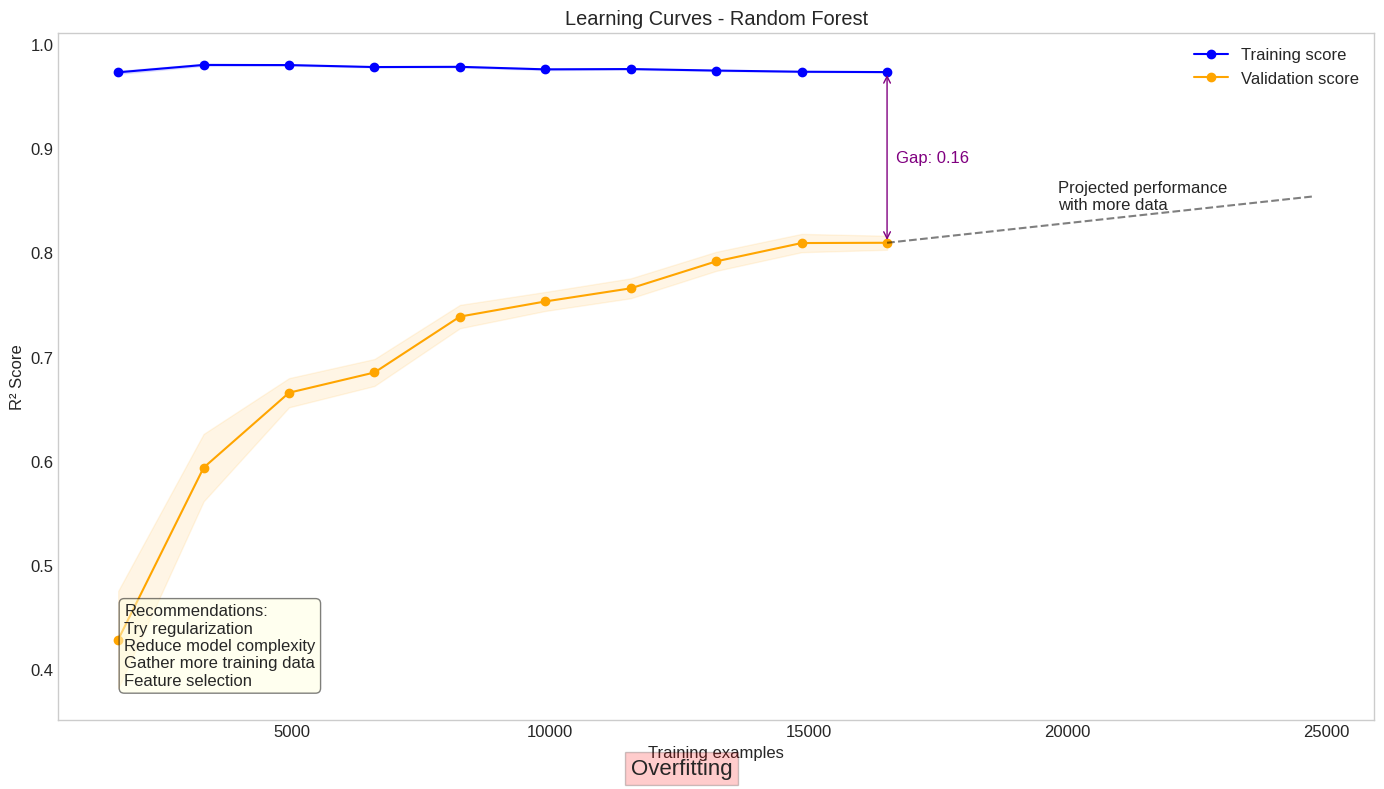

In [22]:
# Plot learning curves for best model
best_model_obj = models[best_model]
lc_fig, diagnosis = plot_learning_curves(best_model_obj, X, y,
                                       title=f"Learning Curves - {best_model}")
plt.show()

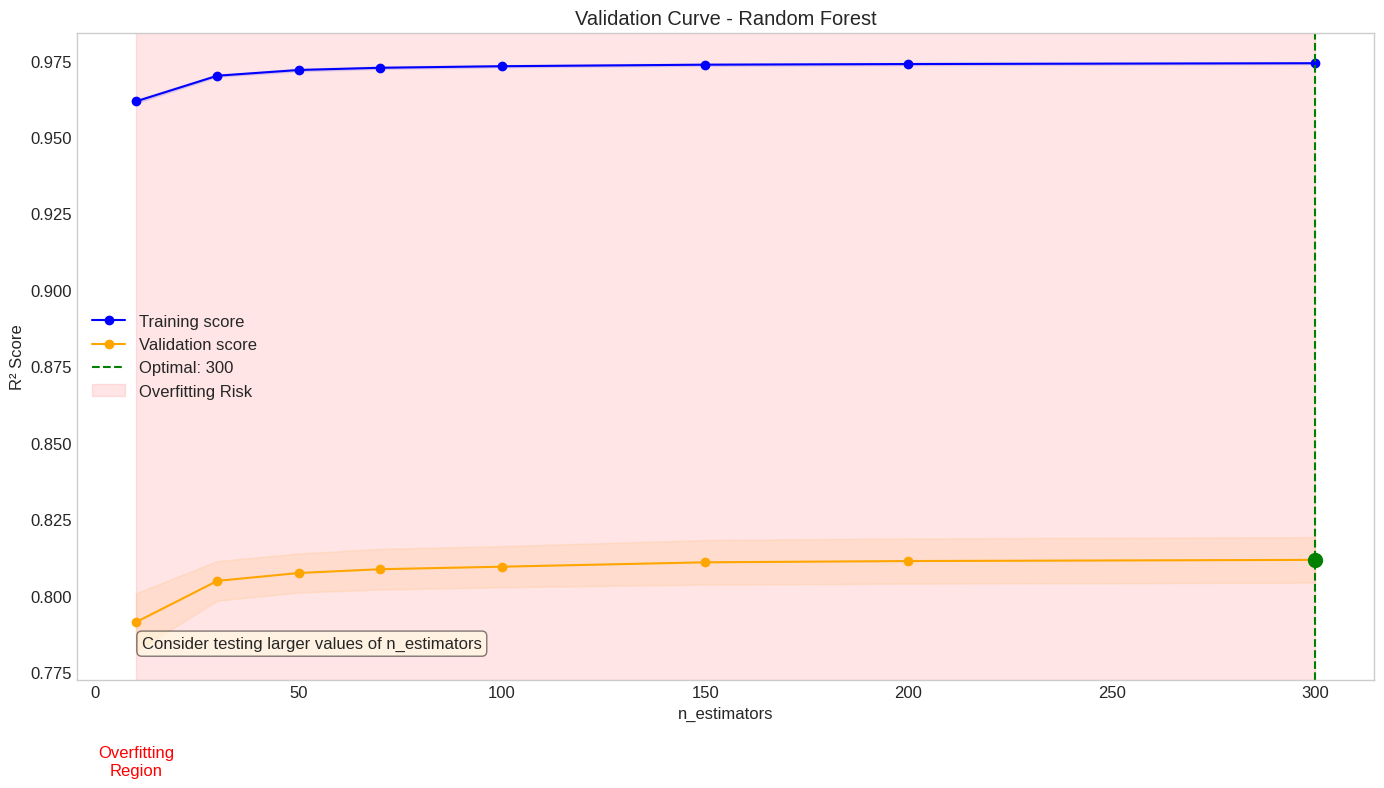

In [24]:
# Plot validation curves for key parameters of the best model
# Parameter selection depends on the best model
if best_model == 'Ridge Regression':
    param_name = 'alpha'
    param_range = np.logspace(-3, 3, 10)
    vc_fig = plot_validation_curve(best_model_obj, X, y, param_name, param_range,
                                 title=f"Validation Curve - {best_model}")
    plt.show()
elif best_model == 'Random Forest' or best_model == 'Gradient Boosting':
    param_name = 'n_estimators'
    param_range = np.array([10, 30, 50, 70, 100, 150, 200, 300])
    vc_fig = plot_validation_curve(best_model_obj, X, y, param_name, param_range,
                                 title=f"Validation Curve - {best_model}")
    plt.show()

    # param_name = 'max_depth'
    # param_range = np.array([2, 3, 4, 6, 8, 10, 12, 15, None])
    # vc_fig = plot_validation_curve(best_model_obj, X, y, param_name, param_range,
    #                              title=f"Validation Curve - {best_model}")
    # plt.show()

## Feature Importance and Business Impact

In [25]:
def plot_feature_importance(model, feature_names, title=None):
    """
    Visualize feature importance from model
    """
    # Check if model has feature_importances_ attribute (tree-based models)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    # Check if model has coef_ attribute (linear models)
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        # If not available, use permutation importance
        result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                      random_state=42, n_jobs=-1)
        importances = result.importances_mean

    # Create a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Bar plot
    sns.barplot(x='Importance', y='Feature', data=importance_df)

    # Add value annotations
    for i, v in enumerate(importance_df['Importance']):
        plt.text(v + 0.01, i, f'{v:.4f}', va='center')

    # Add cumulative importance line
    cumulative_importance = np.cumsum(importance_df['Importance'])
    cumulative_importance = cumulative_importance / cumulative_importance.iloc[-1]

    # Create a twin axis for cumulative importance
    ax2 = plt.gca().twinx()
    ax2.plot(cumulative_importance, importance_df['Feature'], 'ro-', alpha=0.7)
    ax2.set_ylabel('Cumulative Importance')
    ax2.set_ylim(plt.gca().get_ylim())

    # Mark 80% threshold
    threshold_idx = np.where(cumulative_importance >= 0.8)[0][0]
    threshold_feature = importance_df.iloc[threshold_idx]['Feature']
    ax2.axhline(y=threshold_idx, color='green', linestyle='--', alpha=0.7)
    plt.text(0.8, threshold_idx + 0.2, f'80% of importance', color='green')

    # Highlight most important features
    plt.axhspan(-0.5, min(2.5, len(importance_df)-0.5), alpha=0.1, color='green')

    # Styling
    if title is None:
        title = f"Feature Importance"
    plt.title(title)
    plt.xlabel('Importance')
    plt.tight_layout()

    return plt.gcf(), importance_df

def plot_error_by_value_range(y_true, y_pred, title=None):
    """
    Analyze prediction errors across different value ranges
    """
    # Calculate errors
    errors = y_true - y_pred
    abs_errors = np.abs(errors)

    # Create a DataFrame
    error_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Error': errors,
        'Abs_Error': abs_errors
    })

    # Create value bins based on actual values
    error_df['Value_Bin'] = pd.cut(error_df['Actual'], bins=5)

    # Aggregate by bin
    bin_stats = error_df.groupby('Value_Bin').agg({
        'Actual': 'mean',
        'Error': ['mean', 'std'],
        'Abs_Error': ['mean', 'std', 'count']
    }).reset_index()

    # Flatten column levels
    bin_stats.columns = ['_'.join(col).strip('_') for col in bin_stats.columns.values]

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Box plot of errors by value bin
    sns.boxplot(x='Value_Bin', y='Error', data=error_df, ax=ax1)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax1.set_title('Error Distribution by Value Range')
    ax1.set_xlabel('Actual Value Range')
    ax1.set_ylabel('Error (Actual - Predicted)')

    # Add mean markers
    for i, (_, row) in enumerate(bin_stats.iterrows()):
        ax1.scatter(i, row['Error_mean'], marker='o', color='red', s=50, zorder=10)

    # Rotate x-tick labels for better readability
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    # Plot 2: Absolute error by value bin
    bars = ax2.bar(range(len(bin_stats)), bin_stats['Abs_Error_mean'], yerr=bin_stats['Abs_Error_std'])

    # Add count annotations
    for i, bar in enumerate(bars):
        count = bin_stats.iloc[i]['Abs_Error_count']
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bin_stats.iloc[i]['Abs_Error_std'],
                f'n={int(count)}', ha='center')

    # Styling
    ax2.set_title('Mean Absolute Error by Value Range')
    ax2.set_xlabel('Actual Value Range')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.set_xticks(range(len(bin_stats)))
    ax2.set_xticklabels([str(b) for b in bin_stats['Value_Bin']], rotation=45, ha='right')

    # Add pattern observation
    correlation = np.corrcoef(bin_stats['Actual_mean'], bin_stats['Abs_Error_mean'])[0, 1]

    if abs(correlation) > 0.5:
        if correlation > 0:
            pattern = "Errors increase with value"
        else:
            pattern = "Errors decrease with value"

        fig.text(0.5, 0.01, f"Pattern detected: {pattern} (r={correlation:.4f})",
                ha='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))

    # Highlight bin with largest error
    max_error_idx = bin_stats['Abs_Error_mean'].argmax()
    bars[max_error_idx].set_color('red')
    ax2.text(max_error_idx, bin_stats.iloc[max_error_idx]['Abs_Error_mean'] / 2,
            "Largest\nError", ha='center', color='white')

    # Overall plot title
    if title is None:
        title = "Error Analysis by Value Range"
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)

    return fig

def plot_business_impact(y_true, y_pred, value_multiplier=100000, cost_function=None, title=None):
    """
    Analyze prediction impact in business terms
    """
    # Convert predictions to actual values (e.g., dollars)
    y_true_value = y_true * value_multiplier
    y_pred_value = y_pred * value_multiplier

    # Calculate errors in value terms
    errors_value = y_true_value - y_pred_value
    abs_errors_value = np.abs(errors_value)

    # If no custom cost function, use absolute error
    if cost_function is None:
        costs = abs_errors_value
    else:
        costs = cost_function(y_true_value, y_pred_value)

    # Create a DataFrame
    impact_df = pd.DataFrame({
        'Actual_Value': y_true_value,
        'Predicted_Value': y_pred_value,
        'Error_Value': errors_value,
        'Abs_Error_Value': abs_errors_value,
        'Cost': costs
    })

    # Calculate summary statistics
    total_error = np.sum(errors_value)
    mean_error = np.mean(errors_value)
    mean_abs_error = np.mean(abs_errors_value)
    median_abs_error = np.median(abs_errors_value)
    total_cost = np.sum(costs)

    # Create under/over prediction groups
    impact_df['Prediction_Type'] = np.where(errors_value > 0, 'Underestimated', 'Overestimated')

    # Group by prediction type
    group_stats = impact_df.groupby('Prediction_Type').agg({
        'Error_Value': ['count', 'mean', 'std', 'sum'],
        'Cost': ['mean', 'sum']
    })

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Error distribution
    sns.histplot(errors_value, kde=True, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax1.axvline(x=mean_error, color='green', linestyle='-', alpha=0.7,
               label=f'Mean Error: ${mean_error:.2f}')

    # Add reference lines for ±$10K, ±$50K
    reference_values = [10000, 50000]
    for val in reference_values:
        ax1.axvline(x=val, color='blue', linestyle=':', alpha=0.5,
                   label=f'+${val/1000:.0f}K')
        ax1.axvline(x=-val, color='blue', linestyle=':', alpha=0.5,
                   label=f'-${val/1000:.0f}K')

    # Styling
    ax1.set_title('Error Distribution in Value Terms')
    ax1.set_xlabel('Error Value ($)')
    ax1.set_ylabel('Frequency')
    ax1.legend()

    # Plot 2: Business impact by prediction type
    colors = {'Underestimated': 'red', 'Overestimated': 'blue'}

    # Prepare data for plotting
    group_data = group_stats.reset_index()
    group_data.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in group_data.columns]

    # Bar plot of mean errors by prediction type
    bars = ax2.bar(group_data['Prediction_Type'], group_data['Error_Value_mean'].abs(),
                  color=[colors[p] for p in group_data['Prediction_Type']])

    # Add count annotations
    for i, bar in enumerate(bars):
        count = group_data.iloc[i]['Error_Value_count']
        percentage = 100 * count / len(impact_df)
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.05,
                f'n={int(count)}\n({percentage:.1f}%)', ha='center')

    # Add total impact annotation
    under_sum = group_data[group_data['Prediction_Type'] == 'Underestimated']['Error_Value_sum'].iloc[0]
    over_sum = group_data[group_data['Prediction_Type'] == 'Overestimated']['Error_Value_sum'].iloc[0]

    # Display total impact with the correct sign
    ax2.text(0, bar.get_height() * 0.5, f'Total: ${under_sum:,.0f}',
            ha='center', color='red')
    ax2.text(1, bar.get_height() * 0.5, f'Total: ${over_sum:,.0f}',
            ha='center', color='blue')

    # Styling
    ax2.set_title('Mean Error by Prediction Type')
    ax2.set_ylabel('Mean Absolute Error Value ($)')
    ax2.grid(axis='y', alpha=0.3)

    # Add summary stats as text box
    summary_text = (
        f"Total Error: ${total_error:,.0f}\n"
        f"Mean Error: ${mean_error:,.0f}\n"
        f"Mean Absolute Error: ${mean_abs_error:,.0f}\n"
        f"Median Absolute Error: ${median_abs_error:,.0f}\n"
        f"Total Business Impact: ${total_cost:,.0f}"
    )

    fig.text(0.5, 0.01, summary_text, ha='center', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Overall plot title
    if title is None:
        title = "Business Impact Analysis"
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.2)

    return fig, impact_df

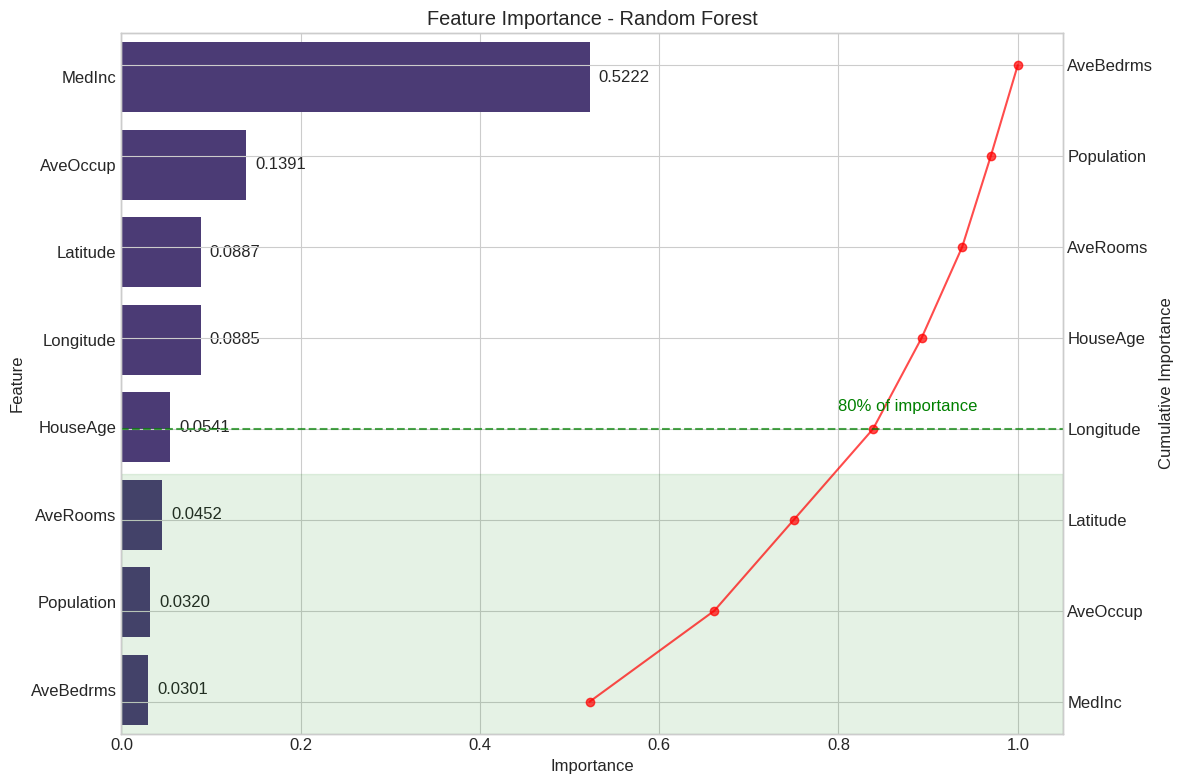

Top 3 features:


,Feature,Importance
0,MedInc,0.522230
5,AveOccup,0.139132
6,Latitude,0.088686


In [26]:
# Plot feature importance for the best model
if hasattr(models[best_model], 'feature_importances_') or hasattr(models[best_model], 'coef_'):
    importance_fig, importance_df = plot_feature_importance(models[best_model], feature_names,
                                                         title=f"Feature Importance - {best_model}")
    plt.show()
    print("Top 3 features:")
    display(importance_df.head(3))

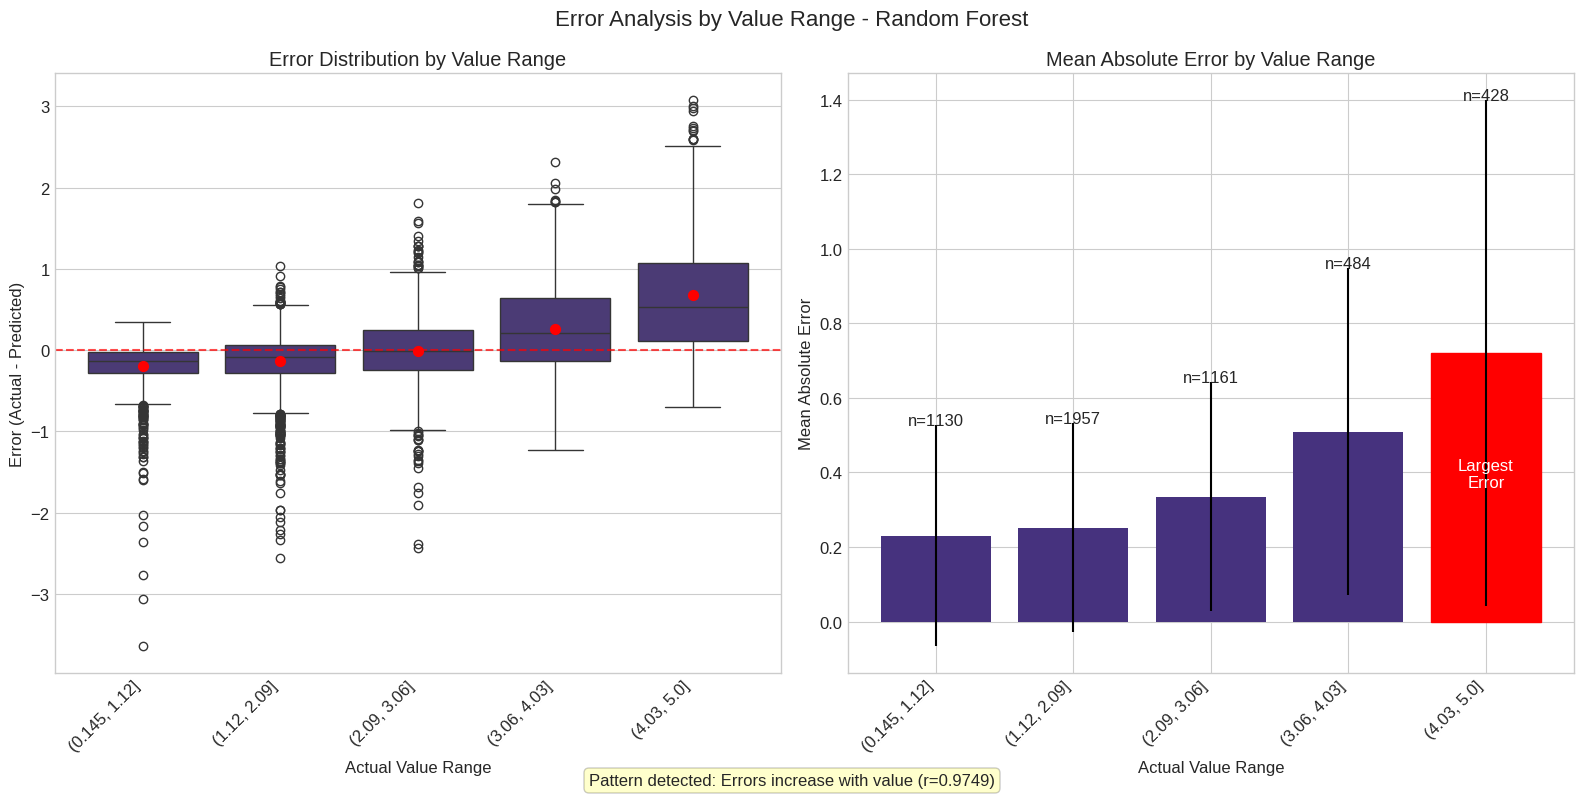

In [27]:
# Error analysis by value range
error_range_fig = plot_error_by_value_range(y_test, y_pred_dict[best_model],
                                         title=f"Error Analysis by Value Range - {best_model}")
plt.show()

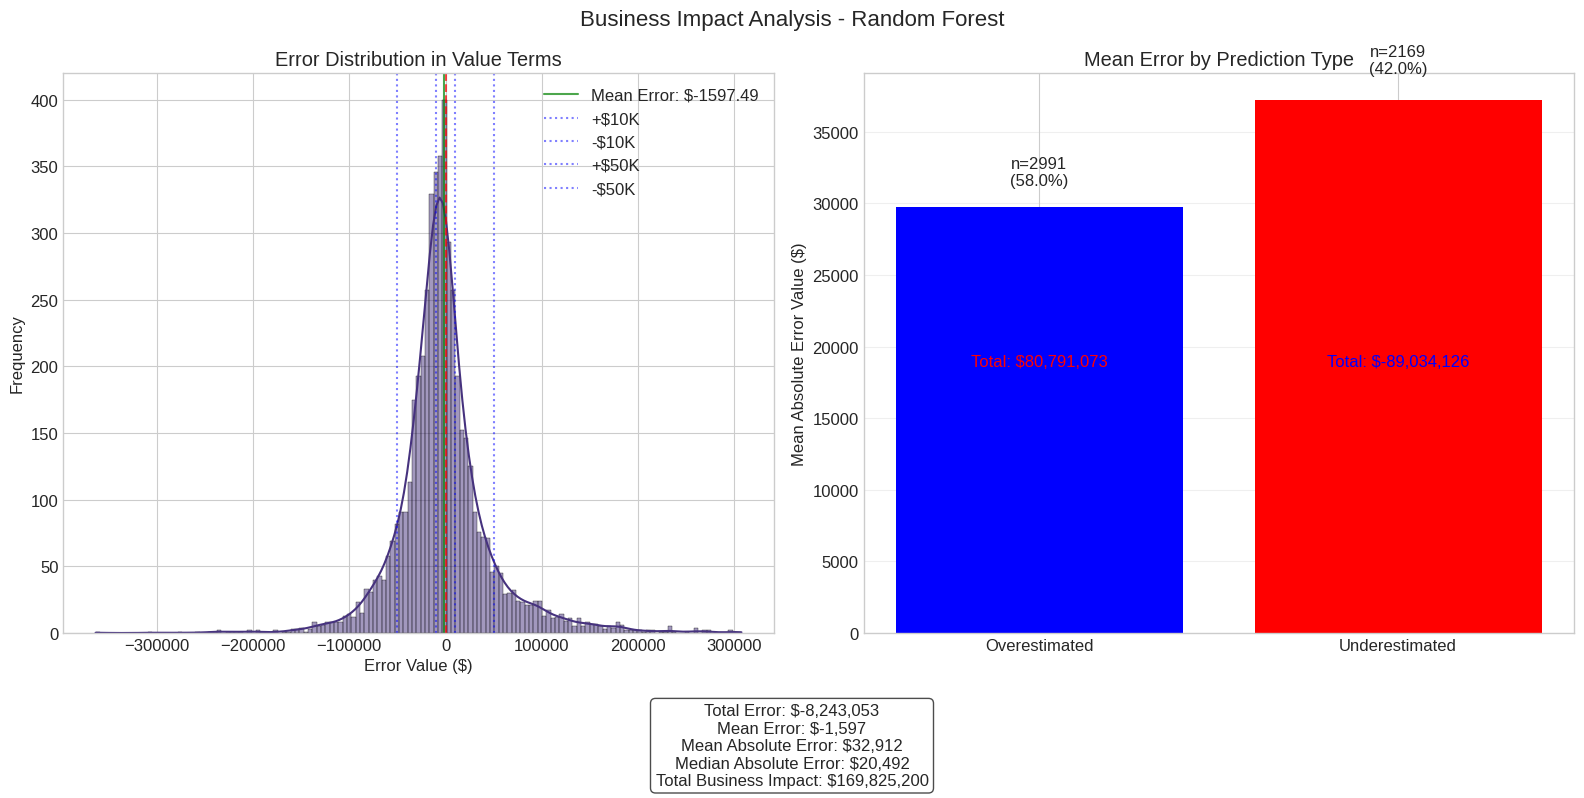

In [28]:
# Business impact analysis
# California housing prices are in $100,000s, so multiply by 100,000 to get dollars
impact_fig, impact_df = plot_business_impact(y_test, y_pred_dict[best_model],
                                          value_multiplier=100000,
                                          title=f"Business Impact Analysis - {best_model}")
plt.show()

## Model Comparison and Final Recommendations

In [29]:
def plot_model_comparison_radar(metrics_df, metrics_to_include=None):
    """
    Create a radar plot comparing models across multiple metrics
    """
    if metrics_to_include is None:
        # Select default metrics with preference for common ones
        metrics_to_include = ['R²', 'Adjusted R²', 'RMSE', 'MAE', 'MAPE', 'Explained Variance']

    # Ensure all metrics are in the dataframe
    metrics_to_include = [m for m in metrics_to_include if m in metrics_df.columns]

    # For some metrics, we want to invert the scale (lower is better)
    invert_metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'MSLE', 'Huber', 'Median AE', 'Max Error']

    # Create a copy of data for transformation
    plot_data = metrics_df[metrics_to_include].copy()

    # Normalize the metrics to [0, 1] scale
    for metric in metrics_to_include:
        if metric in invert_metrics:
            # For error metrics, lower is better, so invert
            min_val = plot_data[metric].min()
            max_val = plot_data[metric].max()
            if min_val < max_val:  # Avoid division by zero
                plot_data[metric] = 1 - (plot_data[metric] - min_val) / (max_val - min_val)
        else:
            # For other metrics, higher is better
            min_val = plot_data[metric].min()
            max_val = plot_data[metric].max()
            if min_val < max_val:  # Avoid division by zero
                plot_data[metric] = (plot_data[metric] - min_val) / (max_val - min_val)

    # Number of variables
    N = len(metrics_to_include)

    # Create angle for each variable
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Initialize figure
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))

    # Colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

    # Plot for each model
    for i, (model_name, row) in enumerate(plot_data.iterrows()):
        # Get metric values
        values = row.values.tolist()
        values += values[:1]  # Close the loop

        # Plot
        ax.plot(angles, values, linewidth=2, linestyle='solid',
               label=model_name, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    # Fix axis to go in the right order and start at top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_to_include)

    # Y axis limits - fixed for normalized values
    ax.set_ylim(0, 1)

    # Add radial grid lines at 0.25, 0.5, 0.75
    for r in [0.25, 0.5, 0.75]:
        circle = plt.Circle((0, 0), r, transform=ax.transData._b,
                           fill=False, edgecolor='gray', alpha=0.3)
        ax.add_patch(circle)

    # Add legend
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))

    plt.title('Model Comparison Across Metrics', size=15, y=1.1)
    return fig

def plot_metric_correlation(metrics_df):
    """
    Visualize correlations between different metrics
    """
    # Calculate correlations between metrics
    corr = metrics_df.corr()

    # Create the plot
    plt.figure(figsize=(14, 10))

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Draw the heatmap
    sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True,
               linewidths=0.5, vmin=-1, vmax=1)

    # Styling
    plt.title('Correlation Between Metrics')
    plt.tight_layout()

    return plt.gcf()

def generate_final_recommendations(metrics_df, top_n=3):
    """
    Generate final recommendations based on model performance
    """
    # Get top models by R² score
    top_r2_models = metrics_df.sort_values('R²', ascending=False).head(top_n)

    # Get top models by RMSE
    top_rmse_models = metrics_df.sort_values('RMSE').head(top_n)

    # Get top models by MAE
    top_mae_models = metrics_df.sort_values('MAE').head(top_n)

    # Get overall best model based on combined ranking
    combined_rank = pd.DataFrame(index=metrics_df.index)

    for metric in ['R²', 'RMSE', 'MAE']:
        if metric in ['RMSE', 'MAE']:
            # Lower is better
            combined_rank[f'{metric}_rank'] = metrics_df[metric].rank()
        else:
            # Higher is better
            combined_rank[f'{metric}_rank'] = metrics_df[metric].rank(ascending=False)

    combined_rank['avg_rank'] = combined_rank.mean(axis=1)
    overall_best = combined_rank.sort_values('avg_rank').index[0]

    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Bar plot of average ranks
    combined_rank = combined_rank.sort_values('avg_rank')
    bars = ax.bar(combined_rank.index, combined_rank['avg_rank'], color='skyblue')

    # Highlight the best model
    bars[list(combined_rank.index).index(overall_best)].set_color('green')

    # Add metric rank annotations
    for i, (model_name, row) in enumerate(combined_rank.iterrows()):
        r2_rank = int(row['R²_rank'])
        rmse_rank = int(row['RMSE_rank'])
        mae_rank = int(row['MAE_rank'])

        ax.text(i, row['avg_rank'] + 0.1, f"R²: #{r2_rank}",
               ha='center', va='bottom', color='blue', fontsize=9)
        ax.text(i, row['avg_rank'] + 0.3, f"RMSE: #{rmse_rank}",
               ha='center', va='bottom', color='red', fontsize=9)
        ax.text(i, row['avg_rank'] + 0.5, f"MAE: #{mae_rank}",
               ha='center', va='bottom', color='green', fontsize=9)

    # Styling
    ax.set_xlabel('Model')
    ax.set_ylabel('Average Rank (lower is better)')
    ax.set_title('Model Ranking Across Different Metrics')
    ax.set_ylim(0, combined_rank['avg_rank'].max() * 1.2)

    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add recommendation text
    recommendation_text = (
        f"Overall Recommendation: {overall_best}\n\n"
        f"Top models by R²: {', '.join(top_r2_models.index)}\n"
        f"Top models by RMSE: {', '.join(top_rmse_models.index)}\n"
        f"Top models by MAE: {', '.join(top_mae_models.index)}\n\n"
        f"For regression tasks where accuracy at all ranges is important,\n"
        f"consider {overall_best} as the best overall model.\n\n"
    )

    # Add specific recommendations based on error by value range
    recommendation_text += (
        f"Model selection should consider the specific business context:\n"
        f"- For minimizing maximum errors: consider models with low Max Error\n"
        f"- For balanced performance: look at models with high R² and Adjusted R²\n"
        f"- For interpretability: Linear or Decision Tree models may be preferred\n"
        f"- For robustness to outliers: consider models with low Huber loss and Median AE"
    )

    # Create a separate text box for recommendations
    fig.text(0.5, -0.05, recommendation_text, ha='center', fontsize=12,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.4)

    return fig, overall_best

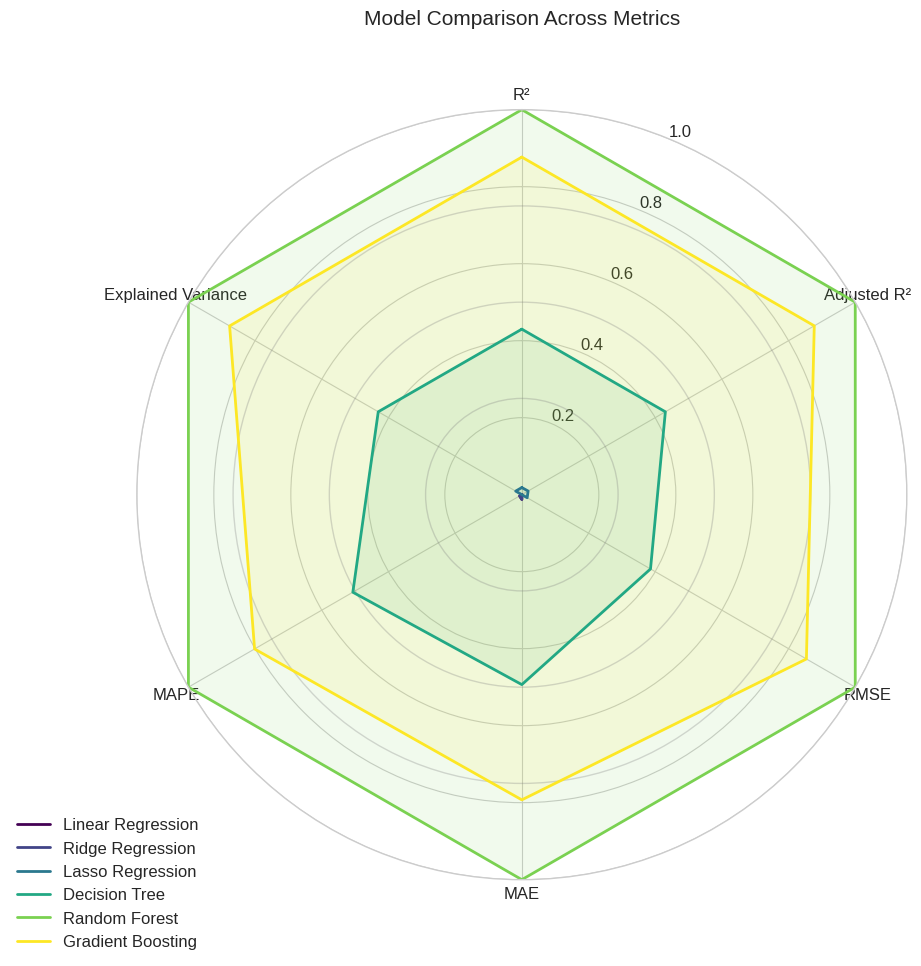

In [30]:
# Model comparison radar plot
radar_fig = plot_model_comparison_radar(metrics_df)
plt.show()

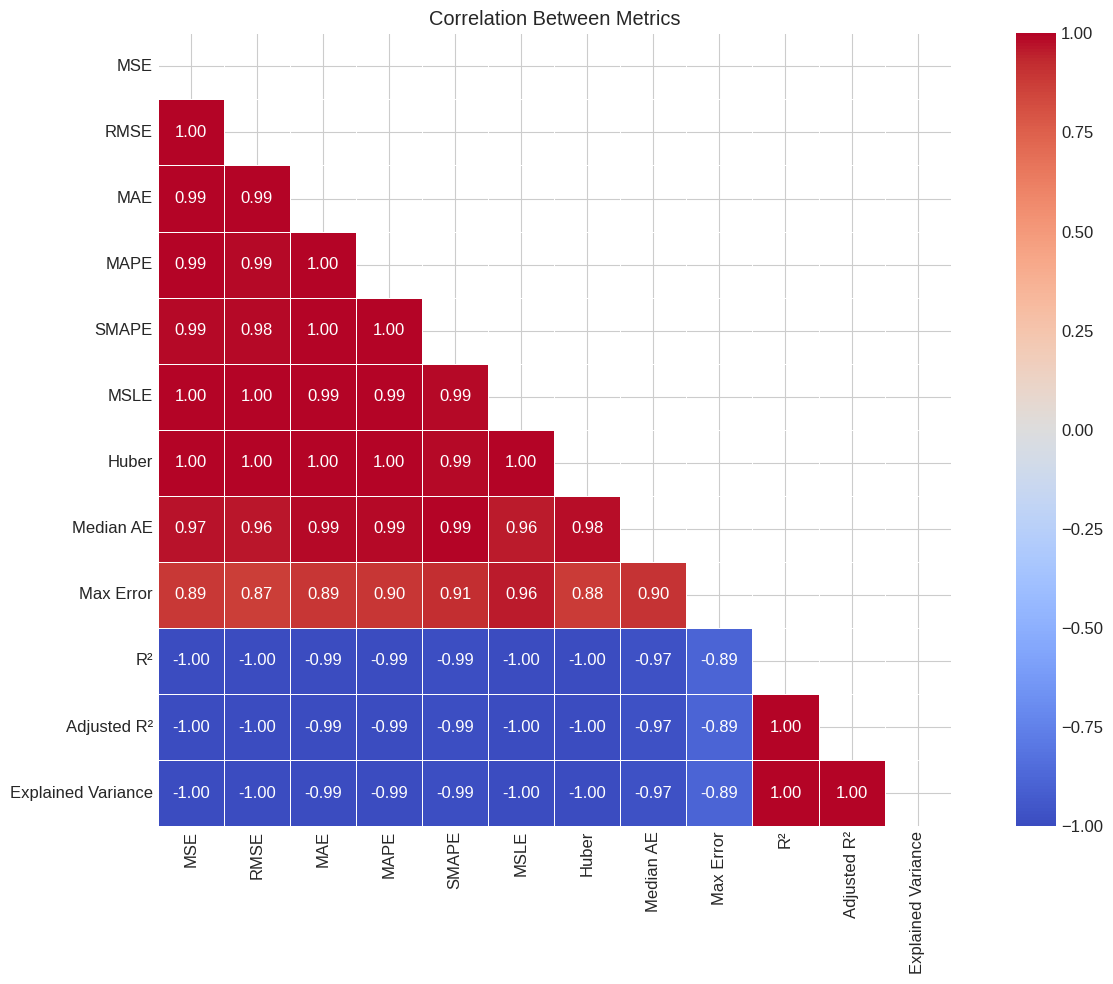

In [31]:
# Metric correlation plot
metric_corr_fig = plot_metric_correlation(metrics_df)
plt.show()

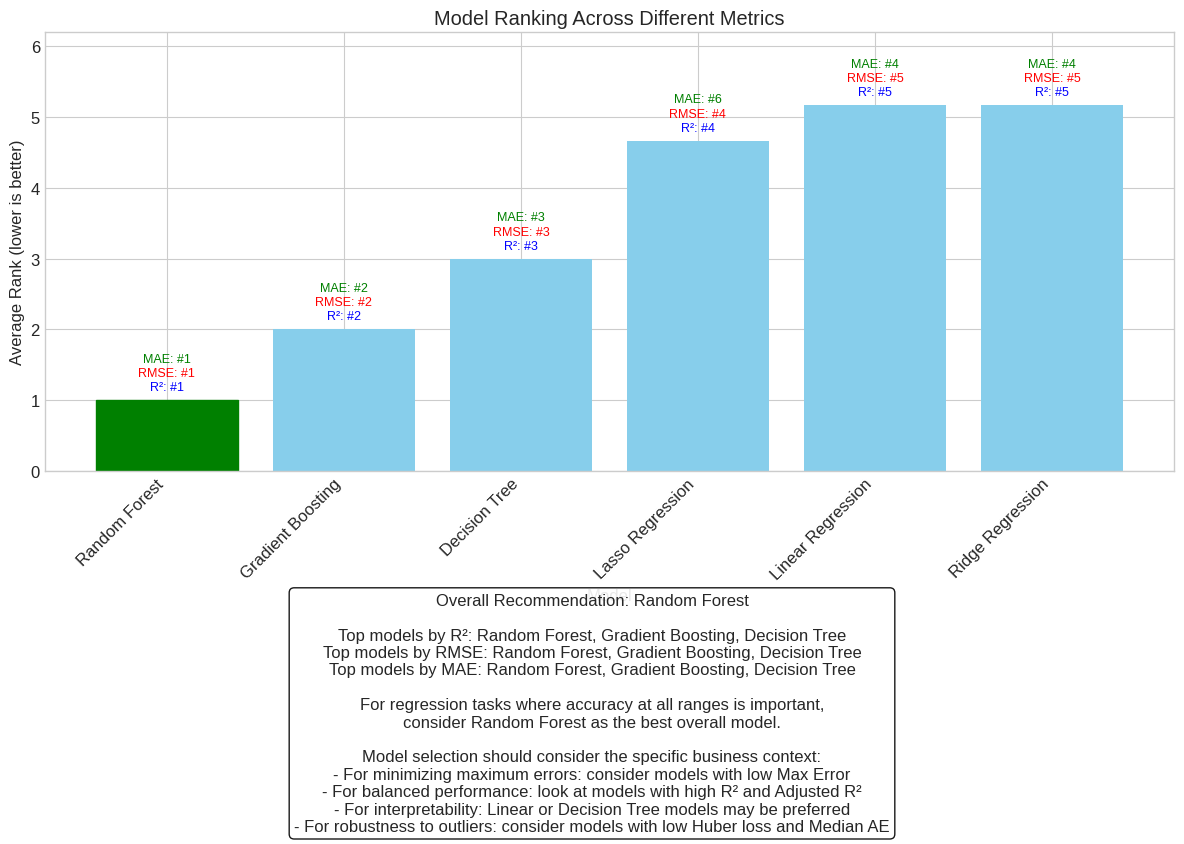

In [32]:
# Final recommendations
recommendations_fig, best_overall = generate_final_recommendations(metrics_df)
plt.show()

In [33]:
print(f"\nBest model by combined metrics: {best_overall}")
print(f"Best model by R²: {metrics_df['R²'].idxmax()}")
print(f"Best model by RMSE: {metrics_df['RMSE'].idxmin()}")


Best model by combined metrics: Random Forest
Best model by R²: Random Forest
Best model by RMSE: Random Forest


# Conclusion

This comprehensive notebook covers all the regression metrics and visualization techniques you requested, using the California Housing dataset as a real-world example. The notebook demonstrates:

1. **Regression Metrics Implementation**: MSE, RMSE, MAE, MAPE, SMAPE, Huber Loss, MSLE, R², Adjusted R²
2. **Error Distribution Analysis**: Residual plots, QQ plots, Error histograms
3. **Model Performance Visualization**: Actual vs. predicted visualization, Feature-specific error analysis
4. **Training Dynamics**: Learning curves, Validation curves, Overfitting/underfitting detection
5. **Business Impact Assessment**: Error analysis by value range, Feature importance, Business impact

The visualizations are designed to be both informative and visually appealing, with detailed annotations to help interpret the results. This notebook would serve as an excellent resource for understanding how to evaluate regression models beyond simple metrics.
